In [1]:
# script to identify model parameters that contribute most to uncertainty using local uncertainty

In [2]:
# script to save the rankings for the mechanism
import os
import sys
import copy
import yaml
import pickle
import pandas as pd
import subprocess

import numpy as np
import rmgpy.chemkin
import cantera as ct



import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
import re
import glob
import rmgpy.data.kinetics


In [4]:
# sys.path.append('/work/westgroup/harris.se/autoscience/reaction_calculator/database/')
sys.path.append('/home/moon/autoscience/reaction_calculator/database/')
import importlib
import database_fun
importlib.reload(database_fun)

using default DFT_DIR
using default DFT_DIR


<module 'database_fun' from '/home/moon/autoscience/reaction_calculator/database/database_fun.py'>

In [5]:
# basedir = '/work/westgroup/harris.se/autoscience/fuels/butane/small_lib_20230929'
# basedir = '/work/westgroup/harris.se/autoscience/fuels/butane/small_lib_20231110'
# basedir = '/work/westgroup/harris.se/autoscience/fuels/butane/base24_analysis'
basedir = '/home/moon/hw8/bill_green_kinetics/project/base24_analysis'

cantera_file = os.path.join(basedir, 'chem_annotated.yaml')
base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport, use_chemkin_names=True)

gas = ct.Solution(cantera_file)
perturbed_cti_path = os.path.join(basedir, 'perturbed.yaml')
perturbed_gas = ct.Solution(perturbed_cti_path)

# This cti -> rmg converter dictionary can be made using rmg_tools/ct2rmg_dict.py
RMG_TOOLS_DIR = '/home/harris.se/rmg/rmg_tools'
if not os.path.exists(os.path.join(basedir, 'ct2rmg_rxn.pickle')):
    print('Creating ct2rmg pickle')
    subprocess.run(['python', os.path.join(RMG_TOOLS_DIR, 'ct2rmg_dict.py'), base_chemkin])

with open(os.path.join(basedir, 'ct2rmg_rxn.pickle'), 'rb') as handle:
    ct2rmg_rxn = pickle.load(handle)
    


print(f'{len(species_list)} species loaded')
print(f'{len(reaction_list)} reactions loaded')

110 species loaded
1822 reactions loaded


/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Chebyshev reaction equation: Specifying '(+M)' in the reaction equation for Chebyshev reactions is deprecated.
On line 3874 of /home/moon/hw8/bill_green_kinetics/project/base24_analysis/perturbed.yaml:
|  Line |
|  3869 |     Reaction index: Chemkin #239; RMG #239
|  3870 |     Template reaction: Disproportionation
|  3871 |     Flux pairs: HCO(19), C2H4(11); C2H5(33), CH2O(9);
|  3872 |     Estimated from node Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCNNNSSS_N-2R!H->S_5R!H->O_1CNS->C
|  3873 |     Multiplied by reaction path degeneracy 3.0
>  3874 > - equation: CH3(18) (+M) <=> H(14) + CH2(23) (+M)  # Reaction 240
            ^
|  3875 |   type: Chebyshev
|  3876 |   temperature-range: [300.0, 2000.0]
|  3877 |   pressure-range: [0.01 atm, 98.692 atm]

  from ipykernel import kernelapp as app


In [6]:
N = len(gas.species())
M = len(gas.reactions())

In [7]:
rxn_uncertainty_file = os.path.join(basedir, 'gao_reaction_uncertainty.npy')
sp_uncertainty_file = os.path.join(basedir, 'gao_species_uncertainty.npy')

rmg_rxn_uncertainty = np.load(rxn_uncertainty_file)
rmg_sp_uncertainty = np.load(sp_uncertainty_file)

assert len(rmg_rxn_uncertainty) == len(reaction_list)
assert len(rmg_sp_uncertainty) == len(species_list)


rxn_uncertainty = np.zeros(len(gas.reactions()))
for ct_index in range(len(rxn_uncertainty)):
    rxn_uncertainty[ct_index] = rmg_rxn_uncertainty[ct2rmg_rxn[ct_index]]

# Cantera species should be in same rmg order, but this makes sure for us
for i in range(len(species_list)):
    assert str(species_list[i]) == gas.species_names[i]

sp_uncertainty = rmg_sp_uncertainty

total_uncertainty_array = np.concatenate((sp_uncertainty, rxn_uncertainty), axis=0)
total_uncertainty_mat = np.repeat(np.transpose(np.matrix(total_uncertainty_array)), 12 * 51, axis=1)



In [8]:
len(ct2rmg_rxn)

1850

## Gather Uncertainty Rankings

In [9]:
SPECIES_DFT_ERROR = 3.0
REACTION_DFT_ERROR = 1 / np.sqrt(3) * np.log(10)


sp_dft_uncertainty_mat = np.ones((N, 12 * 51)) * SPECIES_DFT_ERROR
rxn_dft_uncertainty_mat = np.ones((M, 12 * 51)) * REACTION_DFT_ERROR
dft_uncertainty_mat = np.concatenate((sp_dft_uncertainty_mat, rxn_dft_uncertainty_mat), axis=0)
# dft_uncertainty_mat = np.repeat(np.transpose(np.matrix(dft_uncertainty_mat)), 12 * 51, axis=1)


reaction_indices = np.arange(0, len(gas.reactions()))
reaction_uncertainty_order = [x for _,x in sorted(zip(rxn_uncertainty, reaction_indices))][::-1]

In [10]:
print('Top Uncertain Reactions')
print('i\tDelta\tReaction\tSensitivity\tImprovement Score')
for i in range(0, 10):
    ct_index = reaction_uncertainty_order[i]
    print(ct_index, '\t', np.round(rxn_uncertainty[ct_index], 3),
          '\t', gas.reactions()[ct_index], 
          '\t', reaction_list[ct2rmg_rxn[ct_index]].family)
#           '\t', f'{reaction_sensitivities[ct_index]:.3e}',
#           '\t', f'{improvement_score[ct_index]:.3e}')
    

Top Uncertain Reactions
i	Delta	Reaction	Sensitivity	Improvement Score
1251 	 28.541 	 C3H5O(129) + H(14) <=> C3H4O(74) + H2(13) 	 Disproportionation
1248 	 28.541 	 C3H5O(129) + CH3(18) <=> C3H4O(74) + CH4(10) 	 Disproportionation
1242 	 28.541 	 C3H5O(129) + CH2(23) <=> C3H4O(74) + CH3(18) 	 Disproportionation
1001 	 28.541 	 C2H5O(49) + CH2(23) <=> CH3(18) + CH3CHO(35) 	 Disproportionation
1000 	 28.541 	 C2H5O(49) + CH3(18) <=> CH3CHO(35) + CH4(10) 	 Disproportionation
958 	 28.541 	 CH2(23) + S(777) <=> CH3(18) + S(252) 	 Disproportionation
955 	 28.541 	 H(14) + S(777) <=> H2(13) + S(252) 	 Disproportionation
953 	 28.541 	 CH3(18) + S(777) <=> CH4(10) + S(252) 	 Disproportionation
790 	 28.541 	 C4H8(748) + CH3(18) <=> C4H7(190) + CH4(10) 	 Disproportionation
780 	 28.541 	 C4H8(748) + CH2(23) <=> C4H7(190) + CH3(18) 	 Disproportionation


## Gather Sensitivity Rankings

In [11]:
# load the giant base delays matrix
base_delay_file = os.path.join(basedir, 'total_base_delays.npy')
base_delays = np.load(base_delay_file)

# Load the giant delays matrix
total_delay_file = os.path.join(basedir, 'total_perturbed_mech_delays.npy')
total_delays = np.load(total_delay_file)

assert total_delays.shape[1] == len(base_delays)

total_base_delays = np.repeat(np.matrix(base_delays), total_delays.shape[0], axis=0)
total_base_delays[total_base_delays == 0] = np.nan
assert total_base_delays.shape == total_delays.shape

total_delays[total_delays == 0] = np.nan


In [12]:
d_ln_tau = np.log(total_delays) - np.log(total_base_delays)

In [13]:
avg_d_ln_tau = np.nanmean(d_ln_tau, axis = 1)
avg_d_ln_tau[np.isnan(avg_d_ln_tau)] = -np.inf

/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


### Get $\Delta G$ or $\Delta \ln k$ for each parameter

In [14]:
phi_dicts = []

for table_index in range(1, 13):
    
    # Load the experimental conditions
#     ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
    ignition_delay_data = '/home/moon/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
    df_exp = pd.read_csv(ignition_delay_data)
    table_exp = df_exp[df_exp['Table'] == table_index]
    # Define Initial conditions using experimental data
    tau_exp = table_exp['time (ms)'].values.astype(float)  # ignition delay
    T7 = table_exp['T_C'].values  # Temperatures
    P7 = table_exp['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm
    phi7 = table_exp['phi'].values  # equivalence ratios
    # list of starting conditions
    # Mixture compositions taken from table 2 of
    # https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
    concentrations = []
    # for phi = 1
    x_diluent = 0.7649
    conc_dict = {
        'O2(2)': 0.2038,
        'butane(1)': 0.03135
    }

    
    x_N2 = table_exp['%N2'].values[0] / 100.0 * x_diluent
    x_Ar = table_exp['%Ar'].values[0] / 100.0 * x_diluent
    x_CO2 = table_exp['%CO2'].values[0] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    
    phi_dicts.append(conc_dict)
        
        

In [15]:
# There are 12 * K different simulation settings. We need each parameter estimate at each setting
# Create a matrix with temperatures and one with pressures
T = np.linspace(663, 1077, 51)
table_temperatures = np.repeat(np.matrix(T), 12, axis=1)
temperatures = np.repeat(table_temperatures, total_delays.shape[0], axis=0)

pressures = np.zeros(temperatures.shape)
for i in range(pressures.shape[1]):
    if int(i / 51) in [0, 3, 6, 9]:
        pressures[:, i] = 10.0 * 101325.0
    elif int(i / 51) in [1, 4, 7, 10]:
        pressures[:, i] = 20.0 * 101325.0
    elif int(i / 51) in [2, 5, 8, 11]:
        pressures[:, i] = 30.0 * 101325.0

In [16]:
G_base = np.zeros((N, total_delays.shape[1]))
G_perturbed = np.zeros((N, total_delays.shape[1]))


# get base G values

mod_gas = ct.Solution(cantera_file)
for j in range(N):
    for i in range(temperatures.shape[1]):
    
        T = temperatures[0, i]
        gas.TPX = T, pressures[0, i], phi_dicts[int(i / 51)]
        G_base[j, i] = gas.species()[j].thermo.h(T) - T * gas.species()[j].thermo.s(T)


In [17]:
# Get perturned G values

mod_gas = ct.Solution(cantera_file)
for j in range(N):
#     print(j)
    # change just the one reaction
    mod_gas.modify_species(j, perturbed_gas.species()[j])
    
    for i in range(temperatures.shape[1]):
    
        T = temperatures[0, i]
        mod_gas.TPX = T, pressures[0, i], phi_dicts[int(i / 51)]
        G_perturbed[j, i] = mod_gas.species()[j].thermo.h(T) - T * mod_gas.species()[j].thermo.s(T)

    mod_gas.modify_species(j, gas.species()[j])

In [18]:
# In theory, delta G should be 10% G_base, but apparently it isn't...
# G has units Enthalpy [J/kg or J/kmol] it's J / kmol
delta_G = G_perturbed - G_base
delta_G_kcal_mol = delta_G / 4.184 / 1000.0 / 1000.0  # needs to be kcal/mol to match Gao paper

### Now do reaction rate

In [19]:
# except we know that by definition, this is 0.1
delta_ln_k = 0.1 * np.ones((M, total_delays.shape[1]))

In [20]:
# concatenate into a big delta matrix
delta = np.concatenate((delta_G_kcal_mol, delta_ln_k), axis=0)

### Put it all together into $\frac{\partial \ln \tau}{\partial G}$ or $\frac{\partial \ln \tau}{\partial \ln k}$

In [21]:
# first derivative is change in delay / change in G
first_derivative = np.divide(d_ln_tau, delta)

In [22]:
avg_first_derivative = np.nanmean(first_derivative, axis=1)
abs_avg_first_derivative = np.abs(avg_first_derivative)
abs_avg_first_derivative[np.isnan(abs_avg_first_derivative)] = -np.inf
# avg_first_derivative[np.isnan(avg_first_derivative)] = -np.inf

parameter_indices = np.arange(0, N + M)
# reaction_sensitivity_order = [x for _, x in sorted(zip(avg_first_derivative, parameter_indices))][::-1]
reaction_sensitivity_order = [x for _, x in sorted(zip(abs_avg_first_derivative, parameter_indices))][::-1]

print('Top Sensitive Parameters')
print('i\tDelta\tReaction\tSensitivity\tImprovement Score')
for i in range(0, 10):
    ct_index = reaction_sensitivity_order[i]
    
    if ct_index < N:
#         print(ct_index, '\t', np.round(avg_first_derivative[ct_index,0], 9),
#               '\t', gas.species()[ct_index], )
        print(ct_index, '\t', np.round(abs_avg_first_derivative[ct_index,0], 9),
              '\t', gas.species()[ct_index], )
    else:
#         print(ct_index, '\t', np.round(avg_first_derivative[ct_index,0], 9),
#               '\t', gas.reactions()[ct_index - N])
        print(ct_index, '\t', np.round(abs_avg_first_derivative[ct_index,0], 9),
              '\t', gas.reactions()[ct_index - N])

/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


Top Sensitive Parameters
i	Delta	Reaction	Sensitivity	Improvement Score
419 	 0.641619751 	 OH(15) + butane(1) <=> H2O(8) + PC4H9(182)
378 	 0.530904293 	 OH(15) + butane(1) <=> H2O(8) + SC4H9(183)
380 	 0.347532302 	 HO2(16) + butane(1) <=> H2O2(17) + SC4H9(183)
412 	 0.32371318 	 O2(2) + S(223) <=> S(229)
410 	 0.28706747 	 S(186) <=> C4H8(189) + HO2(16)
455 	 0.249022333 	 O2(2) + S(219) <=> S(225)
130 	 0.246734682 	 2 HO2(16) <=> H2O2(17) + O2(2)
170 	 0.246734629 	 2 HO2(16) <=> H2O2(17) + O2(2)
72 	 0.234526827 	 <Species S(223)>
59 	 0.227483753 	 <Species S(186)>


In [23]:
# for i in range(0, 11):
    
#     ct_index = reaction_sensitivity_order[i]
    
#     if ct_index < N:
#         display(species_list[ct_index])
#     else:
#         display(reaction_list[ct2rmg_rxn[ct_index - N]])

# compute errors for plotting 

In [24]:
total_error = np.multiply(np.float_power(first_derivative, 2.0), np.float_power(total_uncertainty_mat, 2.0))
total_error7 = total_error[:, 6 * 51 : 7 * 51]

In [25]:
base_delays7 = np.load('table_0007/base_delays_0007.npy')
error_slice = total_error7[:,26]

# rank the parameters by error contribution
error_slice[np.isnan(error_slice)] = 0


error_indices = np.arange(0, N + M)
error_order = [x for _, x in sorted(zip(error_slice, error_indices))][::-1]


# get results if we only included top 10 in uncertainty
upper_bound10 = np.ravel(np.array(np.exp(np.log(base_delays7) + np.nansum(total_error7[error_order[0:10], :], 0))))
lower_bound10 = np.ravel(np.array(np.exp(np.log(base_delays7) - np.nansum(total_error7[error_order[0:10], :], 0))))


# get results if we only included top 20 in uncertainty
upper_bound20 = np.ravel(np.array(np.exp(np.log(base_delays7) + np.nansum(total_error7[error_order[0:20], :], 0))))
lower_bound20 = np.ravel(np.array(np.exp(np.log(base_delays7) - np.nansum(total_error7[error_order[0:20], :], 0))))

In [26]:
len(error_order)

1960

In [27]:
# print the worst offenders:
print('Top Error Parameters')
g_params = []
k_params = []
for i in range(0, 11):
    ct_index = error_order[i]
    
    if ct_index < N:
        print(ct_index, '\t', np.round(error_slice[ct_index, 0], 9),
              '\t', gas.species()[ct_index], )
        g_params.append(ct_index)
    else:
        print(ct_index - N, '\t', np.round(error_slice[ct_index, 0], 9),
              '\t', gas.reactions()[ct_index - N])
        k_params.append(ct2rmg_rxn[ct_index - N])


Top Error Parameters
270 	 0.05720428 	 HO2(16) + butane(1) <=> H2O2(17) + SC4H9(183)
5 	 0.036085703 	 <Species O2(2)>
60 	 0.021749516 	 2 HO2(16) <=> H2O2(17) + O2(2)
20 	 0.021749514 	 2 HO2(16) <=> H2O2(17) + O2(2)
58 	 0.015116549 	 <Species S(184)>
72 	 0.014720233 	 <Species S(223)>
309 	 0.012324574 	 OH(15) + butane(1) <=> H2O(8) + PC4H9(182)
59 	 0.012050337 	 <Species S(186)>
268 	 0.008949092 	 OH(15) + butane(1) <=> H2O(8) + SC4H9(183)
311 	 0.007321678 	 HO2(16) + butane(1) <=> H2O2(17) + PC4H9(182)
300 	 0.005679925 	 S(186) <=> C4H8(189) + HO2(16)


In [28]:
rxn_uncertainty.shape

(1850,)

In [29]:
sp_uncertainty.shape

(110,)

0.5


1.5


0.5


0.5


1.5


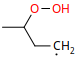

1.5


0.5


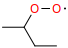

1.5


0.5


0.5


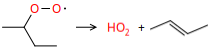

0.5


In [30]:
for i in range(0, 11):
    ct_index = error_order[i]
    
    if ct_index < N:
        display(species_list[ct_index])
        print(sp_uncertainty[ct_index])
    else:
        display(reaction_list[ct2rmg_rxn[ct_index - N]])
        print(rxn_uncertainty[ct_index - N])

In [31]:
reaction_list[ct2rmg_rxn[130]]

In [32]:
reaction_list[ct2rmg_rxn[130]].kinetics

Troe(arrheniusHigh=Arrhenius(A=(4.651e+12,'cm^3/(mol*s)'), n=0.44, Ea=(0,'kcal/mol'), T0=(1,'K')), arrheniusLow=Arrhenius(A=(6.366e+20,'cm^6/(mol^2*s)'), n=-1.72, Ea=(0.525,'kcal/mol'), T0=(1,'K')), alpha=0.5, T3=(1e-30,'K'), T1=(1e+30,'K'), efficiencies={Molecule(smiles="[O][O]"): 0.78, Molecule(smiles="[H][H]"): 2.0, Molecule(smiles="[He]"): 0.8, Molecule(smiles="[C-]#[O+]"): 1.9, Molecule(smiles="O"): 14.0, Molecule(smiles="O=C=O"): 3.8, Molecule(smiles="[Ar]"): 0.67})

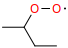

In [33]:
species_list[59]

In [34]:
species_list[59].smiles

'CCC(C)O[O]'

In [35]:
g_params

[5, 58, 72, 59]

In [36]:
k_params

[249, 18, 18, 288, 247, 290, 279]

In [37]:
ct2rmg_rxn[270]

249

In [38]:
reaction_list[ct2rmg_rxn[270]]

In [39]:
np.nansum(total_error7, 0)

matrix([[2.45285216, 2.41560389, 2.45611795, 2.58536196, 2.83289066,
         3.13273729, 3.59634399, 4.24547967, 5.03837776, 5.87783386,
         6.61761481, 7.09049737, 7.12699012, 6.56952661, 5.42448804,
         4.01899584, 2.79373426, 1.91872427, 1.3397263 , 0.96080255,
         0.71009102, 0.54194616, 0.42822143, 0.35135419, 0.30009667,
         0.26703374, 0.24714355, 0.23695122, 0.23401626, 0.23661237,
         0.24352131, 0.25389626, 0.26716733, 0.28297219, 0.30110057,
         0.32144448, 0.34394797, 0.36855839, 0.39517494, 0.42359867,
         0.45349492, 0.48436437, 0.5155402 , 0.54620585, 0.57542859,
         0.60222951, 0.6256557 , 0.64485478, 0.65914923, 0.66809232,
         0.67150937]])

In [40]:
base_delays7 = np.load('table_0007/base_delays_0007.npy')

Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
Tmin = 663
K = 51
temperatures = np.linspace(Tmin, Tmax, K)

In [41]:
upper_bound = np.ravel(np.array(np.exp(np.log(base_delays7) + np.np.nansum(total_error7, 0))))
lower_bound = np.ravel(np.array(np.exp(np.log(base_delays7) - np.nansum(total_error7, 0))))

In [53]:
upper_bound_stddev = np.ravel(np.array(np.exp(np.log(base_delays7) + np.float_power(np.nansum(total_error7, 0), 0.5))))
lower_bound_stddev = np.ravel(np.array(np.exp(np.log(base_delays7) - np.float_power(np.nansum(total_error7, 0), 0.5))))

In [42]:
T7

array([679, 677, 677, 690])

In [43]:
base_delays = np.array([0.04908327, 0.0485444 , 0.04814444, 0.04868172, 0.07558788,
       0.07737167, 0.14791668, 0.14857534, 0.1085917 , 0.0952434 ,
       0.06520823, 0.05563237, 0.03535775, 0.02462961, 0.02334903,
       0.01398333])

In [44]:
# Load the experimental conditions
ignition_delay_data = '/home/moon/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
# ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'

df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 1
x_diluent = 0.7649
conc_dict = {
    'O2(2)': 0.2038,
    'butane(1)': 0.03135
}

for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)


In [45]:
tau7

array([86.5 , 73.9 , 31.3 , 33.  , 30.9 , 30.  , 56.  , 56.6 , 67.9 ,
       66.4 , 65.2 , 67.1 , 47.  , 27.9 , 28.05, 12.  ])

In [46]:
T7

array([700, 701, 731, 732, 756, 757, 794, 795, 840, 849, 872, 881, 906,
       926, 929, 959])

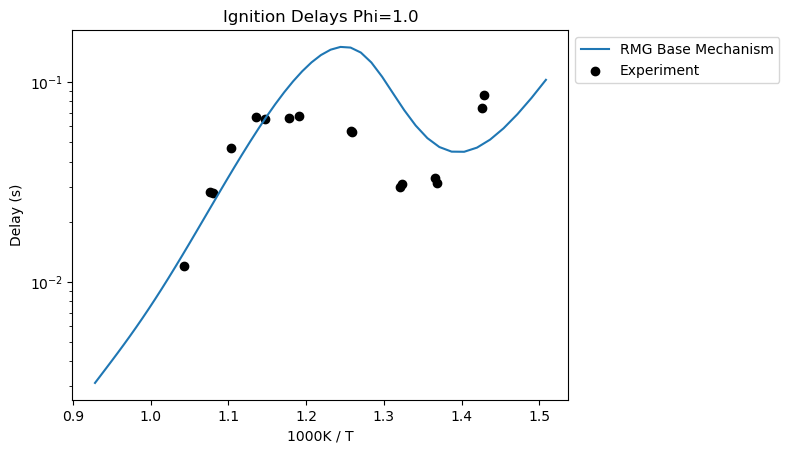

In [47]:
# plot the ignition delay
# plt.plot(1000.0 / T7, base_delays, marker='x', label='RMG Base Mechanism')
plt.plot(1000.0 / temperatures, base_delays7, label='RMG Base Mechanism')
# plt.plot(1000.0 / temperatures, base_delays7, marker='x', label='RMG Base Mechanism')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')

ax = plt.gca()
ax.set_yscale('log')
plt.legend()
# plt.legend(['Mechanism 174', 'Base RMG', 'Aramco', 'Experiment'])
# plt.legend(['RMG 24', 'RMG 1 week', 'Aramco', 'new calculation', 'Experiment'], loc=(1.04, 0))
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
plt.legend(bbox_to_anchor=(1, 1))

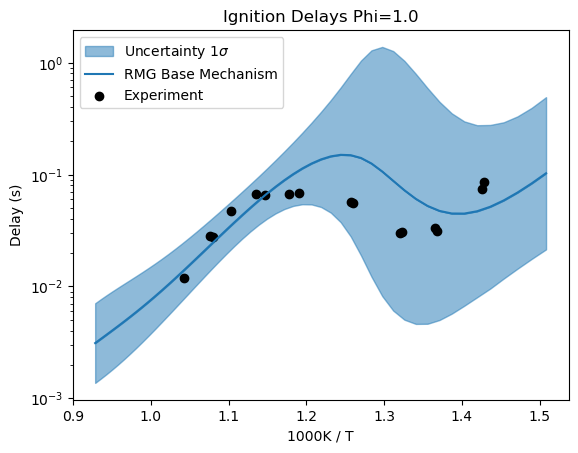

In [57]:
# plot the ignition delay
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# plt.plot(1000.0 / T7, base_delays, marker='x', label='RMG Base Mechanism')

plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev.transpose(), alpha=0.5, color=colors[0], label=r'Uncertainty 1$\sigma$')
plt.fill_between(1000.0 / temperatures, lower_bound_stddev.transpose(), base_delays7, alpha=0.5, color=colors[0])


plt.plot(1000.0 / temperatures, base_delays7, label='RMG Base Mechanism')




# plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound.transpose(), alpha=1.0, color=colors[0], label='Uncertainty (All)')
# plt.fill_between(1000.0 / temperatures, lower_bound.transpose(), base_delays7, alpha=1.0, color=colors[0])


plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')

ax = plt.gca()
ax.set_yscale('log')
plt.legend()

# plt.xlim([0.9, 1.2])
# plt.ylim([0.001, 1.0])

plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
# plt.savefig('table7.png')
plt.legend(loc='upper left')
# plt.legend(bbox_to_anchor=(1.1, 1))

In [48]:
np.array(upper_bound).ravel()

array([1.19281476e+00, 9.32018293e-01, 8.04413576e-01, 7.78660183e-01,
       8.75504830e-01, 1.07740139e+00, 1.63272576e+00, 3.12988782e+00,
       7.29384927e+00, 1.87072782e+01, 4.53220006e+01, 8.68201983e+01,
       1.09381952e+02, 7.58752037e+01, 2.84439991e+01, 7.82028908e+00,
       2.43254968e+00, 1.02171329e+00, 5.54724738e-01, 3.57000305e-01,
       2.55262238e-01, 1.94768570e-01, 1.54803154e-01, 1.26321859e-01,
       1.04902770e-01, 8.81746321e-02, 7.47621883e-02, 6.38113713e-02,
       5.47585991e-02, 4.72115083e-02, 4.08840536e-02, 3.55595396e-02,
       3.10686397e-02, 2.72757544e-02, 2.40701714e-02, 2.13600766e-02,
       1.90683032e-02, 1.71292782e-02, 1.54866927e-02, 1.40917178e-02,
       1.29017187e-02, 1.18792369e-02, 1.09913030e-02, 1.02091299e-02,
       9.50776732e-03, 8.86621324e-03, 8.26747643e-03, 7.69862974e-03,
       7.15080275e-03, 6.61894337e-03, 6.10137682e-03])

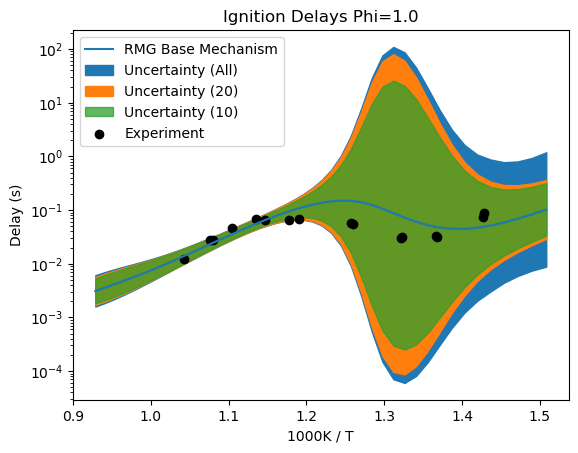

In [49]:
# plot the ignition delay
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# plt.plot(1000.0 / T7, base_delays, marker='x', label='RMG Base Mechanism')
plt.plot(1000.0 / temperatures, base_delays7, label='RMG Base Mechanism')


plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound.transpose(), alpha=1.0, color=colors[0], label='Uncertainty (All)')
plt.fill_between(1000.0 / temperatures, lower_bound.transpose(), base_delays7, alpha=1.0, color=colors[0])


plt.fill_between(1000.0 / temperatures, lower_bound20.transpose(), base_delays7, alpha=1.0, color=colors[1])
plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound20.transpose(), alpha=1.0, color=colors[1], label='Uncertainty (20)')


plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound10.transpose(), alpha=.75, color=colors[2], label='Uncertainty (10)')
plt.fill_between(1000.0 / temperatures, lower_bound10.transpose(), base_delays7, alpha=.75, color=colors[2])


plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')

ax = plt.gca()
ax.set_yscale('log')
plt.legend()

# plt.xlim([0.9, 1.2])
# plt.ylim([0.001, 1.0])

plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
# plt.savefig('table7.png')
plt.legend(loc='upper left')
# plt.legend(bbox_to_anchor=(1.1, 1))

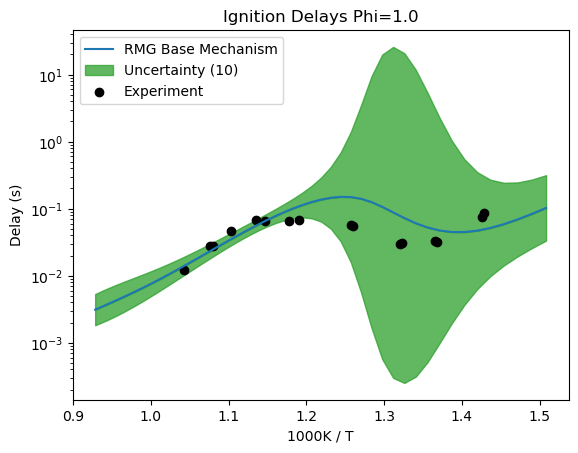

In [50]:
# plot the ignition delay uncertainty of just the top 10 parameters
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# plt.plot(1000.0 / T7, base_delays, marker='x', label='RMG Base Mechanism')
plt.plot(1000.0 / temperatures, base_delays7, label='RMG Base Mechanism')

plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound10.transpose(), alpha=.75, color=colors[2], label='Uncertainty (10)')
plt.fill_between(1000.0 / temperatures, lower_bound10.transpose(), base_delays7, alpha=.75, color=colors[2])


plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')

ax = plt.gca()
ax.set_yscale('log')
plt.legend()

# plt.xlim([0.9, 1.2])
# plt.ylim([0.001, 1.0])

plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
# plt.savefig('table7.png')
plt.legend(loc='upper left')
# plt.legend(bbox_to_anchor=(1.1, 1))

In [ ]:
# global results: variance at 1000K: array([0.00012554])
global1000_mean = 0.02010513
global1000_var = 0.00012554

In [ ]:
temperatures[-10]

In [ ]:
global_upper

In [ ]:
global_lower

In [ ]:
# convert to plot

# get results if we only included top 10 in uncertainty
# global_upper = np.exp(np.log(base_delays7[-10]) + global1000_var)
# global_lower = np.exp(np.log(base_delays7[-10]) - global1000_var)


global_upper = np.exp(np.log(global1000_mean) + global1000_var)
global_lower = np.exp(np.log(global1000_mean) - global1000_var)






# print(len(global_lower))

In [ ]:
global_lower

In [ ]:
global_upper

In [ ]:
global1000_mean

In [ ]:
global1000_var

In [ ]:
global929_mean = 4.947e-02
global929_std = 2.408e-02
global929_var = np.float_power(2.408e-02, 2.0)

In [ ]:
# 959  mean  3.153e-02    std  1.582e-02 
global959_mean = 3.153e-02
global959_std = 1.582e-02 
global959_var = np.float_power(global700_std, 2.0)

In [ ]:
global700_mean = 0.06848727
global700_std = 0.004039
global700_var = np.float_power(global700_std, 2.0)

In [ ]:
global_lower = np.exp(np.log(global700_mean) - global700_var)

In [ ]:
global_lower

In [ ]:
np.exp(np.log(global700_mean) + global700_var)

In [ ]:
# 929..  mean 4.947e-02     std 2.408e-02
# 959  mean  3.153e-02    std  1.582e-02 

In [ ]:
# plot the ignition delay uncertainty of just the top 10 parameters
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# plt.plot(1000.0 / T7, base_delays, marker='x', label='RMG Base Mechanism')
plt.plot(1000.0 / temperatures, base_delays7, label='RMG Base Mechanism')

plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound10.transpose(), alpha=.75, color=colors[0], label='Local Uncertainty (10)')
plt.fill_between(1000.0 / temperatures, lower_bound10.transpose(), base_delays7, alpha=.75, color=colors[0])


plt.errorbar(1000.0 / 1000, global1000_mean, yerr=global1000_var, fmt='*', label='PCE', color=colors[1])

plt.errorbar(1000.0 / 929, global929_mean, yerr=global929_var, fmt='*',color=colors[1])

plt.errorbar(1000.0 / 959, global959_mean, yerr=global929_var, fmt='*',color=colors[1])

plt.errorbar(1000.0 / 700, global700_mean, yerr=global700_var, fmt='*', color=colors[1])



# plt.scatter(1000.0 / 1000, global1000_mean, color='red', label='PCE')
# plt.scatter(1000.0 / 1000, global_upper, color='blue', label='PCE')
# plt.scatter(1000.0 / 1000, global_lower, color='blue', label='PCE')


plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')

ax = plt.gca()
ax.set_yscale('log')
plt.legend()

# plt.xlim([0.9, 1.2])
# plt.ylim([0.001, 1.0])

plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
# plt.savefig('table7.png')
plt.legend(loc='upper left')
# plt.legend(bbox_to_anchor=(1.1, 1))

In [ ]:
# record the means and stds
Ts = [700, 701, 731, 732, 756, 757, 794, 795, 840, 849, 872, 881, 906, 926, 929, 959, ]
means = [8.228e-02, 8.238e-02, 1.480e-01, 1.522e-01, 1.650e-01, 1.841e-01, 1.572e-01, 1.537e-01, 1.618e-01, 1.668e-01, 1.313e-01, 1.187e-01, 7.441e-02, 4.823e-02, 4.585e-02, 2.871e-02]
stds = [7.156e-02, 7.331e-02, 1.398e-01, 1.422e-01, 2.227e-01, 2.335e-01, 1.116e-01, 1.091e-01, 1.017e-01, 1.048e-01, 7.090e-02, 5.987e-02, 3.578e-02, 2.313e-02, 2.198e-02, 1.417e-02]
varis = np.float_power(stds, 2.0)

# lowers = np.exp(np.log(means) - np.float_power(stds, 1.0))
# uppers = np.exp(np.log(means) + np.float_power(stds, 1.0))


# lowers = np.log10(means) - np.float_power(stds, 2.0)
# uppers = np.log10(means) + np.float_power(stds, 2.0)

# lowers = np.divide(means, np.exp(stds))
# uppers = np.multiply(means, np.exp(stds))

# # lowers = np.divide(means, np.float_power(10.0, stds))
# # uppers = np.multiply(means, np.float_power(10.0, stds))

lowers = np.divide(means, np.float_power(10.0, varis))
uppers = np.multiply(means, np.float_power(10.0, varis))

# lowers = np.float_power(10.0, np.log(means) - np.float_power(stds, 2.0))
# uppers = np.float_power(10.0, np.log(means) + np.float_power(stds, 2.0))

In [ ]:
lowers

In [ ]:
np.exp(0.02)

In [ ]:
np.log(means[i])

In [ ]:
# plot the ignition delay uncertainty of just the top 10 parameters
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# plt.plot(1000.0 / T7, base_delays, marker='x', label='RMG Base Mechanism')
plt.plot(1000.0 / temperatures, base_delays7, label='RMG Base Mechanism')

plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound10.transpose(), alpha=.75, color=colors[0], label='Local Uncertainty (10)')
plt.fill_between(1000.0 / temperatures, lower_bound10.transpose(), base_delays7, alpha=.75, color=colors[0])


for i in range(len(Ts)):
    if i == 0:
        label = 'PCE'
    else:
        label = None
#     plt.errorbar(1000.0 / Ts[i], 0.1, yerr=np.array([[0.1 / np.float_power(10.0, 0.2)]*1, [0.1 * np.float_power(10.0, 0.2)]*1]), fmt='*', label=label, color=colors[1])

#     plt.errorbar(1000.0 / Ts[i], means[i], yerr=np.array([[means[i] / np.float_power(10.0, (stds[i]))]*1, [means[i] * np.float_power(10.0, (stds[i]))]*1]), fmt='*', label=label, color=colors[1])

    plt.errorbar(1000.0 / Ts[i], means[i], yerr=np.array([[stds[i]]*1, [stds[i]]*1]), fmt='*', label=label, color=colors[1])


plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')

ax = plt.gca()
ax.set_yscale('log')
plt.legend()

# plt.xlim([0.9, 1.2])
# plt.ylim([0.001, 1.0])

plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
# plt.savefig('table7.png')
plt.legend(loc='upper left')
# plt.legend(bbox_to_anchor=(1.1, 1))